In [1]:
import numpy as np
from datasets import load_dataset

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import numpy as np

class MyMLP:
    def __init__(self, input_len=784, hLayer1_len=256, hLayer2_len=256, output_len=10,
                 learning_rate=0.001, seed=42, activation="relu",
                 beta1=0.9, beta2=0.999, eps=1e-8):
        np.random.seed(seed)
        # Random initialization of Weights and biases
        self.W1 = np.random.randn(input_len, hLayer1_len) * 0.01
        self.b1 = np.zeros((1, hLayer1_len))
        self.W2 = np.random.randn(hLayer1_len, hLayer2_len) * 0.01
        self.b2 = np.zeros((1, hLayer2_len))
        self.W3 = np.random.randn(hLayer2_len, output_len) * 0.01
        self.b3 = np.zeros((1, output_len))

        self.activation = activation
        self.lr = learning_rate
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.t = 0  # timestep for Adam

        # Adam moment estimates (initialized to zeros)
        self.mW1 = np.zeros_like(self.W1); self.vW1 = np.zeros_like(self.W1)
        self.mb1 = np.zeros_like(self.b1); self.vb1 = np.zeros_like(self.b1)
        self.mW2 = np.zeros_like(self.W2); self.vW2 = np.zeros_like(self.W2)
        self.mb2 = np.zeros_like(self.b2); self.vb2 = np.zeros_like(self.b2)
        self.mW3 = np.zeros_like(self.W3); self.vW3 = np.zeros_like(self.W3)
        self.mb3 = np.zeros_like(self.b3); self.vb3 = np.zeros_like(self.b3)

    # Activation functions
    def relu(self, z): return np.maximum(0, z)
    def derivative_relu(self, z): return (z > 0).astype(float)
    def sigmoid(self, z): return 1 / (1 + np.exp(-z))
    def derivative_sigmoid(self, a): return a * (1 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # Forward pass
    def feedforward(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1) if self.activation == "relu" else self.sigmoid(z1)

        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.relu(z2) if self.activation == "relu" else self.sigmoid(z2)

        z3 = np.dot(a2, self.W3) + self.b3
        a3 = self.softmax(z3)

        return z1, a1, z2, a2, z3, a3

    # Cross-entropy loss
    def crossEntropy(self, y, y_pred):
        m = y.shape[0]
        return -np.sum(y * np.log(y_pred + 1e-9)) / m

    # Backpropagation
    def backProp(self, X, y, z1, a1, z2, a2, z3, a3):
        m = X.shape[0]
        delta3 = (a3 - y) / m
        d_W3 = np.dot(a2.T, delta3)
        d_b3 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = np.dot(delta3, self.W3.T) * (self.derivative_relu(z2) if self.activation=="relu" else self.derivative_sigmoid(a2))
        d_W2 = np.dot(a1.T, delta2)
        d_b2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = np.dot(delta2, self.W2.T) * (self.derivative_relu(z1) if self.activation=="relu" else self.derivative_sigmoid(a1))
        d_W1 = np.dot(X.T, delta1)
        d_b1 = np.sum(delta1, axis=0, keepdims=True)

        return d_W1, d_b1, d_W2, d_b2, d_W3, d_b3

    # Adam update
    def adam_update(self, param, grad, m, v):
        self.t += 1
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

        m_hat = m / (1 - self.beta1 ** self.t)
        v_hat = v / (1 - self.beta2 ** self.t)

        param -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        return param, m, v

    def updateWB(self, d_W1, d_b1, d_W2, d_b2, d_W3, d_b3):
        self.W1, self.mW1, self.vW1 = self.adam_update(self.W1, d_W1, self.mW1, self.vW1)
        self.b1, self.mb1, self.vb1 = self.adam_update(self.b1, d_b1, self.mb1, self.vb1)
        self.W2, self.mW2, self.vW2 = self.adam_update(self.W2, d_W2, self.mW2, self.vW2)
        self.b2, self.mb2, self.vb2 = self.adam_update(self.b2, d_b2, self.mb2, self.vb2)
        self.W3, self.mW3, self.vW3 = self.adam_update(self.W3, d_W3, self.mW3, self.vW3)
        self.b3, self.mb3, self.vb3 = self.adam_update(self.b3, d_b3, self.mb3, self.vb3)

    # Training loop
    def train(self, X, y, X_val, y_val, epochs=50):
        train_losses, val_losses, train_accs, val_accs = [], [], [], []
        for epoch in range(epochs):
            z1, a1, z2, a2, z3, a3 = self.feedforward(X)
            loss = self.crossEntropy(y, a3)
            d_W1, d_b1, d_W2, d_b2, d_W3, d_b3 = self.backProp(X, y, z1, a1, z2, a2, z3, a3)
            self.updateWB(d_W1, d_b1, d_W2, d_b2, d_W3, d_b3)

            # Metrics
            train_losses.append(loss)
            train_accs.append(np.mean(np.argmax(a3, axis=1) == np.argmax(y, axis=1)))

            _, _, _, _, _, a3_val = self.feedforward(X_val)
            val_loss = self.crossEntropy(y_val, a3_val)
            val_losses.append(val_loss)
            val_accs.append(np.mean(np.argmax(a3_val, axis=1) == np.argmax(y_val, axis=1)))

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

        return train_losses, val_losses, train_accs, val_accs

    def predict(self, X):
        _, _, _, _, _, a3 = self.feedforward(X)
        return np.argmax(a3, axis=1)


In [4]:
dataset = load_dataset("ylecun/mnist")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
display(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

##Visualizing the first 25 images of the trainig data

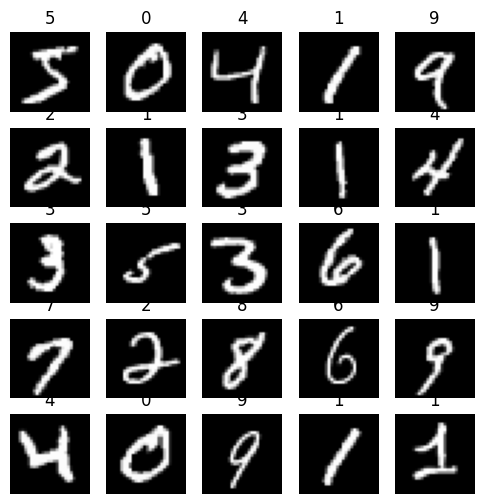

In [6]:
fig, axes = plt.subplots(5,5,figsize=(6,6))
for i, ax in enumerate(axes.flat):
  ax.imshow(dataset["train"][i]["image"], cmap = "gray")
  ax.set_title(dataset["train"][i]["label"])
  ax.axis("off")

In [7]:
#Flatten and Normalize image
X_train = np.array([np.array(img["image"]).flatten() for img in dataset["train"]])/225.0
y_train = np.array([img["label"] for img in dataset["train"]])

X_test = np.array([np.array(img["image"]).flatten() for img in dataset["test"]])/225.0
y_test = np.array([img["label"] for img in dataset["test"]])


In [8]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# One-hot encoding labes
def oneHot(y, num_classes=10):
  return np.eye(num_classes)[y]

y_train_oneHot = oneHot(y_train)
y_val_oneHot = oneHot(y_val)
y_test_oneHot = oneHot(y_test)

Epoch 0, Train Loss: 2.3026, Val Loss: 2.2991
Epoch 10, Train Loss: 1.8436, Val Loss: 1.6771
Epoch 20, Train Loss: 0.6327, Val Loss: 0.6030
Epoch 30, Train Loss: 0.4197, Val Loss: 0.4078
Epoch 40, Train Loss: 0.3353, Val Loss: 0.3286
Epoch 50, Train Loss: 0.2787, Val Loss: 0.2781
Epoch 60, Train Loss: 0.2429, Val Loss: 0.2462
Epoch 70, Train Loss: 0.2122, Val Loss: 0.2200
Epoch 80, Train Loss: 0.1839, Val Loss: 0.1959
Epoch 90, Train Loss: 0.1597, Val Loss: 0.1747
Test Accuracy: 0.9523


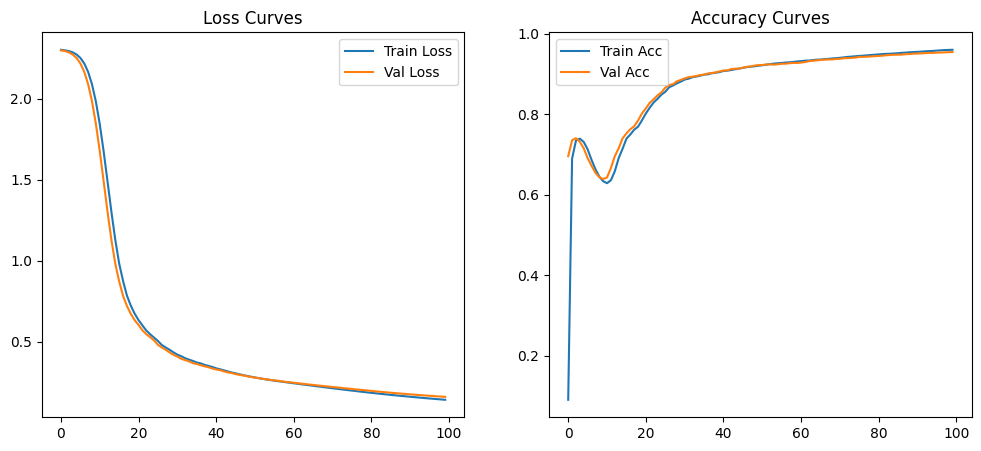

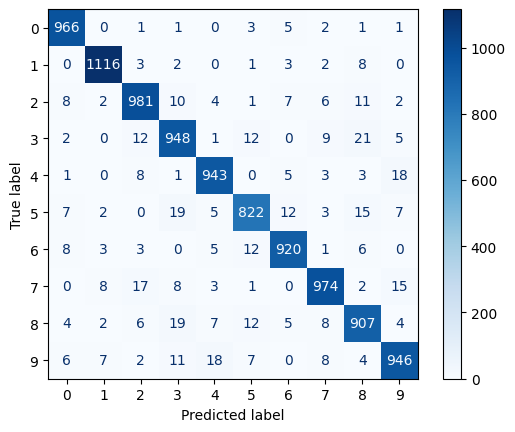

In [10]:
#Train the Network

# Initialize and train
nn = MyMLP(activation="relu")
train_losses,val_losses,train_accs,val_accs = nn.train(X_train,y_train_oneHot, X_val, y_val_oneHot,epochs=100)

# Evaluate
preds = nn.predict(X_test)
accuracy = np.mean(preds == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot losses
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Val Loss")
plt.legend(); plt.title("Loss Curves")

# Plot accuracies
plt.subplot(1,2,2)
plt.plot(train_accs,label="Train Acc")
plt.plot(val_accs,label="Val Acc")
plt.legend(); plt.title("Accuracy Curves")
plt.show()

# Confusion matrix
y_pred = nn.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.show()
